<a href="https://colab.research.google.com/github/YenaChoi00/ML-Final-Project/blob/main/CIFAR10_Classification_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [2]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Inception v3

from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F

__all__ = ['Inception3', 'inception_v3']

_InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])

In [4]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [7]:
# Inception V3
# incremental training comments out that line of code.

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

WORK_DIR = './data'
NUM_EPOCHS = 5
BATCH_SIZE = 4
#LEARNING_RATE = 0.01

MODEL_PATH = './model'
MODEL_NAME = 'Inception_v3.pth'

# Create model
if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)
"""
#AUGMENTATIONS
transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  #torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.5, hue=0.1),
  transforms.RandomHorizontalFlip(),
  torchvision.transforms.RandomVerticalFlip(),
  # torchvision.transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=None,shear=50, resample=False, fillcolor=0),
  torchvision.transforms.RandomRotation((20), resample=False,expand=False, center=None),
  transforms.ToTensor(),
  transforms.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])
])
"""
transforms_cifar10 = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Load data
dataset = torchvision.datasets.CIFAR10(root=WORK_DIR,
                                        download=True,
                                        train=True,
                                        transform=transforms_cifar10)

dataset_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)


classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:05<00:00, 28803727.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


plane  deer   dog horse


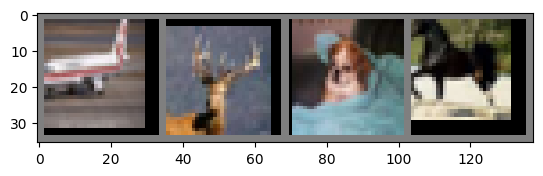

In [9]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [10]:
def inception_v3(pretrained=False, **kwargs):
  
  if pretrained:
    if 'transform_input' not in kwargs:
      kwargs['transform_input'] = True
    if 'aux_logits' in kwargs:
      original_aux_logits = kwargs['aux_logits']
      kwargs['aux_logits'] = True
    else:
      original_aux_logits = True
    model = Inception3(**kwargs)
    if not original_aux_logits:
      model.aux_logits = False
    return model

  return Inception3(**kwargs)

In [11]:
def inception_v3(pretrained=False, **kwargs):
  if pretrained:
    if 'transform_input' not in kwargs:
      kwargs['transform_input'] = True
    if 'aux_logits' in kwargs:
      original_aux_logits = kwargs['aux_logits']
      kwargs['aux_logits'] = True
    else:
      original_aux_logits = True
    model = Inception3(**kwargs)
    if not original_aux_logits:
      model.aux_logits = False
    return model

  return Inception3(**kwargs)


In [12]:
# Inception V3
class Inception3(nn.Module):

  def __init__(self, num_classes=10, aux_logits=True, transform_input=True):
    super(Inception3, self).__init__()
    self.aux_logits = aux_logits
    self.transform_input = transform_input
    self.Conv2d_4a_3x3 = BasicConv2d(3, 32, kernel_size=3,padding=1)
    self.Mixed_5b = InceptionA(32, pool_features=8)
    self.Mixed_5c = InceptionA(64, pool_features=72)
    self.Mixed_6a = InceptionB(128)
    self.Mixed_6b = InceptionC(256, channels_7x7=64)
    if aux_logits:
      self.AuxLogits = InceptionAux(512, num_classes)
    self.Mixed_7a = InceptionD(512)
    self.fc = nn.Linear(768, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        import scipy.stats as stats
        stddev = m.stddev if hasattr(m, 'stddev') else 0.1
        X = stats.truncnorm(-2, 2, scale=stddev)
        values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
        values = values.view(m.weight.size())
        with torch.no_grad():
          m.weight.copy_(values)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    global aux
    print(x.shape) 
    x = self.Conv2d_4a_3x3(x)
    x = self.Mixed_5b(x)
    x = self.Mixed_5c(x)
    x = self.Mixed_6a(x)
    x = self.Mixed_6b(x)
    if self.training and self.aux_logits:
      aux = self.AuxLogits(x)
    x = self.Mixed_7a(x)
    x = F.adaptive_avg_pool2d(x, (1, 1))
    x = F.dropout(x, training=self.training)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    print(x.shape)
    if self.training and self.aux_logits:
      return _InceptionOutputs(x, aux)
    return x

In [13]:
class InceptionA(nn.Module):

  def __init__(self, in_channels, pool_features):
    super(InceptionA, self).__init__()
    self.branch1x1 = BasicConv2d(in_channels, 8, kernel_size=1)

    self.branch5x5_1 = BasicConv2d(in_channels, 8, kernel_size=1)
    self.branch5x5_2 = BasicConv2d(8, 16, kernel_size=5, padding=2)

    self.branch3x3dbl_1 = BasicConv2d(in_channels, 8, kernel_size=1)
    self.branch3x3dbl_2 = BasicConv2d(8, 16, kernel_size=3, padding=1)
    self.branch3x3dbl_3 = BasicConv2d(16, 32, kernel_size=3, padding=1)

    self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

  def forward(self, x):
    branch1x1 = self.branch1x1(x)

    branch5x5 = self.branch5x5_1(x)
    branch5x5 = self.branch5x5_2(branch5x5)

    branch3x3dbl = self.branch3x3dbl_1(x)
    branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
    branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

    branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    branch_pool = self.branch_pool(branch_pool)

    outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
    return torch.cat(outputs, 1)

In [14]:
class InceptionB(nn.Module):

  def __init__(self, in_channels):
    super(InceptionB, self).__init__()
    self.branch3x3 = BasicConv2d(in_channels, 32, kernel_size=3, stride=2)

    self.branch3x3dbl_1 = BasicConv2d(in_channels, 32, kernel_size=1)
    self.branch3x3dbl_2 = BasicConv2d(32, 64, kernel_size=3, padding=1)
    self.branch3x3dbl_3 = BasicConv2d(64, 96, kernel_size=3, stride=2)

  def forward(self, x):
    branch3x3 = self.branch3x3(x)

    branch3x3dbl = self.branch3x3dbl_1(x)
    branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
    branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

    branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

    outputs = [branch3x3, branch3x3dbl, branch_pool]
    return torch.cat(outputs, 1)

In [15]:
class InceptionC(nn.Module):

  def __init__(self, in_channels, channels_7x7):
    super(InceptionC, self).__init__()
    self.branch1x1 = BasicConv2d(in_channels, 128, kernel_size=1)

    c7 = channels_7x7
    self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
    self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
    self.branch7x7_3 = BasicConv2d(c7, 128, kernel_size=(7, 1), padding=(3, 0))

    self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
    self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
    self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
    self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
    self.branch7x7dbl_5 = BasicConv2d(c7, 128, kernel_size=(1, 7), padding=(0, 3))

    self.branch_pool = BasicConv2d(in_channels, 128, kernel_size=1)

  def forward(self, x):
    branch1x1 = self.branch1x1(x)

    branch7x7 = self.branch7x7_1(x)
    branch7x7 = self.branch7x7_2(branch7x7)
    branch7x7 = self.branch7x7_3(branch7x7)

    branch7x7dbl = self.branch7x7dbl_1(x)
    branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
    branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
    branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
    branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

    branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    branch_pool = self.branch_pool(branch_pool)

    outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
    return torch.cat(outputs, 1)

In [16]:
class InceptionD(nn.Module):

  def __init__(self, in_channels):
    super(InceptionD, self).__init__()
    self.branch3x3_1 = BasicConv2d(in_channels, 32, kernel_size=1)
    self.branch3x3_2 = BasicConv2d(32,64, kernel_size=3, stride=2)

    self.branch7x7x3_1 = BasicConv2d(in_channels, 32, kernel_size=1)
    self.branch7x7x3_2 = BasicConv2d(32,64, kernel_size=(1, 7), padding=(0, 3))
    self.branch7x7x3_3 = BasicConv2d(64, 128, kernel_size=(7, 1), padding=(3, 0))
    self.branch7x7x3_4 = BasicConv2d(128,192, kernel_size=3, stride=2)

  def forward(self, x):
    branch3x3 = self.branch3x3_1(x)
    branch3x3 = self.branch3x3_2(branch3x3)

    branch7x7x3 = self.branch7x7x3_1(x)
    branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
    branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
    branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

    branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
    outputs = [branch3x3, branch7x7x3, branch_pool]
    return torch.cat(outputs, 1)
class BasicConv2d(nn.Module):

  def __init__(self, in_channels, out_channels, **kwargs):
    super(BasicConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return F.relu(x, inplace=True)

In [17]:
class InceptionAux(nn.Module):

  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
    self.conv1 = BasicConv2d(128, 512, kernel_size=5)
    self.conv1.stddev = 0.01
    self.fc = nn.Linear(512, num_classes)
    self.fc.stddev = 0.001

  def forward(self, x):
    x = F.avg_pool2d(x, kernel_size=3, stride=3)
    x = self.conv0(x)
    x = self.conv1(x)
    x = F.adaptive_avg_pool2d(x, (1, 1))
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [18]:
class BasicConv2d(nn.Module):

  def __init__(self, in_channels, out_channels, **kwargs):
    super(BasicConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return F.relu(x, inplace=True)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
#loss_fun = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [19]:
import os
import time

import torch
import torch.utils.data
import torchvision
from torchvision import transforms

# Total parameters
model = inception_v3().to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

2534260

## Main 함수

In [20]:
def main():
  print(f"Train numbers:{len(dataset)}")
  LEARNING_RATE = 0.001
  MOMENTUM=0.9
  # first train run this line
  #model = inception_v3().to(device)
  print(model)
  #model_save_name = 'Inception_v3e1.pth'
  #model.load_state_dict(torch.load(MODEL_NAME))
  # Load model
  #if device == 'cuda':

    #model = torch.load(MODEL_PATH + MODEL_NAME).to(device)
  #else:
    #model = torch.load(MODEL_PATH + MODEL_NAME, map_location='cpu')
  # cast
  cast = torch.nn.CrossEntropyLoss().to(device)
  # Optimization
  optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM)
  step = 1
  loss_values=[]
  for epoch in range(1, NUM_EPOCHS + 1):
    print(loss_values)
    model.train()
    running_loss = 0.0
    
    # cal one epoch time
    start = time.time()
    correct = 0
    total = 0
    for images, labels in dataset_loader:
      images = images.to(device)
      print(images.shape)
      labels = labels.to(device)
      
      outputs, aux_outputs = model(images)
      loss1 = cast(outputs, labels)
      loss2 = cast(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
      running_loss =+ loss.item() * images.size(0)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print("epoch: ", epoch)
      print(f"Step [{step * BATCH_SIZE}/{NUM_EPOCHS * len(dataset)}], "
            f"Loss: {loss.item():.8f}.")
      print("Running Loss=",running_loss)
      step += 1
      # equal prediction and acc
      _, predicted = torch.max(outputs.data, 1)
      # val_loader total
      total += labels.size(0)
      # add correct
      correct += (predicted == labels).sum().item()

      print(f"Acc: {correct / total:.4f}.")
        # cal train one epoch time
    end = time.time()
    loss_values.append(running_loss / len(dataset_loader))
    
    print(f"Epoch [{epoch}/{NUM_EPOCHS}], "
          f"time: {end - start} sec!")

    # Save the model checkpoint
    if epoch%20==0:
    #   LEARNING_RATE=LEARNING_RATE/10
    #   torch.save(model, MODEL_PATH + '/' + MODEL_NAME)

      model_save_name = 'Inception_v3_CIFAR10_32BATCH_lr0.001_crop_bflip_rot'+str(epoch)+'.pth'   #WE keep changing this and saving states ,can be found in excel sheet attached
      torch.save(model.state_dict(), model_save_name)
    print("epoch completed and model copy completed")
    
  torch.save(model,MODEL_NAME)
  print(f"Model save to {MODEL_PATH + '/' + MODEL_NAME}.")

In [21]:
if __name__ == '__main__':
  main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247148/250000], Loss: 1.11342728.
Running Loss= 4.453709125518799
Acc: 0.6164.
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247152/250000], Loss: 0.64436114.
Running Loss= 2.577444553375244
Acc: 0.6164.
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247156/250000], Loss: 1.31063175.
Running Loss= 5.242527008056641
Acc: 0.6164.
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247160/250000], Loss: 1.02748287.
Running Loss= 4.109931468963623
Acc: 0.6164.
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247164/250000], Loss: 1.57642460.
Running Loss= 6.305698394775391
Acc: 0.6164.
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
epoch:  5
Step [247168/250000], Loss: 2.42426348.
Running Loss= 9.697053

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

In [ ]:
print(model)

In [ ]:
# Test the trained model with sample
dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
print(outputs_test)

GroundTruth:    cat  ship  ship plane
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
Predicted:   frog  ship  ship plane


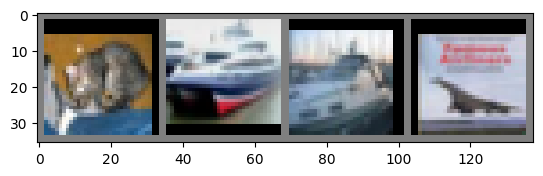

In [22]:
# Test the trained model with sample
dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test, aux_outputs = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [24]:
''# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test, aux_outputs = model(img_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 11 %

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
torc